Filter mappings between New York Times locations and weather stations. Check that distance between station and location "center" is acceptable for each element measured (rain, temperature ...). If not, set mapping to NULL.

In [34]:
from IPython.core.interactiveshell import InteractiveShell
# display output of all cell lines (not only the last one)
#InteractiveShell.ast_node_interactivity = "all"
InteractiveShell.ast_node_interactivity = "last_expr"
from IPython.display import display, HTML

In [47]:
import configparser
import os
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import date, timedelta
from sqlalchemy import create_engine


In [2]:
config = configparser.ConfigParser()
config.read("capstone.cfg")

['capstone.cfg']

In [3]:
project_path = config["PATH"]["project"]
os.chdir(project_path)

# Load mappings

In [4]:
# check multi index read ok 
out_name = os.path.join("OUT_DATA", "closest_stations.csv")
toto = pd.read_csv(out_name, index_col = [0,1])#, skipinitialspace=True)
toto

fips                      county state_gazeeter   station_id  \
SNOW 0     53061.0                   Snohomish     Washington  USW00094290   
     1     17031.0                        Cook       Illinois  USC00111577   
     2      6059.0                      Orange     California  US1CALA0092   
     3      4013.0                    Maricopa        Arizona  USW00023183   
     4      6037.0                 Los Angeles     California  US1CALA0001   
...            ...                         ...            ...          ...   
TAVG 3265      NaN                     Unknown          Idaho  USR0000IHPK   
     3266      NaN                     Unknown        Montana  USS0009C01S   
     3267      NaN                     Unknown         Alaska  USR0000ANOR   
     3268      NaN                     Unknown        Wyoming  USS0007F06S   
     3269   2261.0  Valdez-Cordova Census Area         Alaska  USS0046M04S   

                                           station_name state_station  \
SNOW 0     SEATTLE SAND PT WSFO                                    WA   
     1     CHICAGO MIDWAY AP 3SW                  72534            IL   
     2     REDONDO BEACH 2.1 SSW                                   CA   
     3     PHOENIX SKY HARBOR INTL AP     GSN     72278            AZ   
     4     GLENDALE 2.4 WSW                                        CA   
...                                                 ...           ...   
TAVG 3265  HORTON PEAK IDAHO                                       ID   
     3266  Crystal Lake                                            MT   
     3267  NORUTAK LAKE ALASKA                                     AK   
     3268  Grave Springs                                           WY   
     3269  Sugarloaf Mtn                                           AK   

           latitude_station  longitude_station   distance  
SNOW 0              47.6872          -122.2553  27.427372  
     1              41.7372           -87.7775  10.306315  
     2              33.8274          -118.3888  29.503349  
     3              33.4278          -112.0039  23.435202  
     4              34.1689          -118.2947   2.149035  
...                     ...                ...        ...  
TAVG 3265           43.9481          -114.7561   6.701040  
     3266           46.7900          -109.5100   9.785520  
     3267           66.8333          -154.3333  43.082228  
     3268           43.4700          -107.2400  22.001426  
     3269           61.0800          -146.3000   3.169607  

[19620 rows x 9 columns]

In [5]:
#titi = toto.groupby(level=0).apply(lambda toto: toto.xs(toto.name).to_dict()).to_dict()
# convert multiindex dataframe to dict

# all level 0 index values (i.e. weather elements)
l_weather_elements = toto.index.levels[0]
print(l_weather_elements)
# slice dataframe along elements and make put into dict

titi= { elem : toto.xs(elem) for elem in l_weather_elements }
titi["PRCP"].head()


Index(['PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN'], dtype='object')


,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
0,53061.0,Snohomish,Washington,US1WASN0091,LAKE STEVENS 3.2 N,WA,48.0637,-122.0575,10.878616
1,17031.0,Cook,Illinois,US1ILCK0074,OAK PARK 1.3 NNE,IL,41.9062,-87.7819,5.684991
2,6059.0,Orange,California,USC00044303,IRVINE RCH,CA,33.7200,-117.7231,3.511917
3,4013.0,Maricopa,Arizona,US1AZMR0170,GOODYEAR 5.9 WSW,AZ,33.4066,-112.4485,4.140580
4,6037.0,Los Angeles,California,US1CALA0001,GLENDALE 2.4 WSW,CA,34.1689,-118.2947,2.149035


In [6]:
for elem, lst in titi.items():
    print(elem, len(lst))

PRCP 3270
SNOW 3270
SNWD 3270
TAVG 3270
TMAX 3270
TMIN 3270


In [7]:
dfmi_closest_stations = toto
closest_stations_allinfo = titi

# Outlier analysis functions

In [230]:
dfmi_closest_stations["state_pair"] = list(zip(dfmi_closest_stations["state_gazeeter"], dfmi_closest_stations["state_station"]))

In [231]:
class outlier_identification:
    def __init__(self, df, element, distance_threshold = 100, bins = 100):
        # keep only rows for element
        self.df_elem = df.loc[element]
        display(self.df_elem.loc[:, "distance"].describe())
        # stations too far from location
        self.faraway_stations = self.df_elem[  self.df_elem.loc[:,"distance"]>distance_threshold ] 
        print(self.faraway_stations.shape)
        self.faraway_stations["distance"].hist(bins = bins)
    #    plt.show()
        display( self.faraway_stations[[ "state_gazeeter", "state_station"]].value_counts().to_frame("counts").reset_index())

        self.group_outliers = self.faraway_stations[ ["state_gazeeter", "state_station", "distance"] ]\
            .groupby(["state_gazeeter", "state_station"])\
            .agg( {"distance" : [np.mean, np.median, min, max, len]} )\
            .reset_index()
     ##.sort_values(("distance", "len"), axis = 1)\
        #display(group_outliers.columns)
        self.group_outliers.sort_values([("distance", "len")], inplace = True, ascending = False)
        display(self.group_outliers)
        self.outlier_state_pairs = list(zip( self.group_outliers["state_gazeeter"],  self.group_outliers["state_station"] ))
    
    

# Set outliers to NaN

## SNOW

count    3270.000000
mean       39.104982
std       167.015503
min         0.034007
25%         4.992082
50%        10.530078
75%        18.543485
max      2989.364868
Name: distance, dtype: float64

(99, 10)


,state_gazeeter,state_station,counts
0,Puerto Rico,FL,78
1,Alaska,AK,10
2,Virgin Islands,FL,3
3,Hawaii,CA,3
4,Hawaii,AK,3
5,Northern Mariana Islands,AK,2


state_gazeeter state_station     distance               \
                                                  mean       median   
4               Puerto Rico            FL   829.760633   832.233799   
0                    Alaska            AK   209.624911   164.496379   
1                    Hawaii            AK  1831.544835  1837.397653   
2                    Hawaii            CA  1884.524023  1883.043157   
5            Virgin Islands            FL   903.117387   899.124199   
3  Northern Mariana Islands            AK  2981.368260  2981.368260   

                                   
           min          max   len  
4   770.309777   876.599394  78.0  
0   110.477210   516.924429  10.0  
1  1795.907377  1861.329474   3.0  
2  1880.790043  1889.738869   3.0  
5   892.708535   917.519426   3.0  
3  2973.371651  2989.364868   2.0

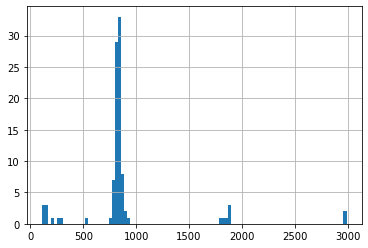

In [201]:
outliers_snow = outlier_identification(dfmi_closest_stations, "SNOW")

In [202]:
outliers_snow.outlier_state_pairs

[('Puerto Rico', 'FL'),
 ('Alaska', 'AK'),
 ('Hawaii', 'AK'),
 ('Hawaii', 'CA'),
 ('Virgin Islands', 'FL'),
 ('Northern Mariana Islands', 'AK')]

In [203]:
outliers_snow.group_outliers

state_gazeeter state_station     distance               \
                                                  mean       median   
4               Puerto Rico            FL   829.760633   832.233799   
0                    Alaska            AK   209.624911   164.496379   
1                    Hawaii            AK  1831.544835  1837.397653   
2                    Hawaii            CA  1884.524023  1883.043157   
5            Virgin Islands            FL   903.117387   899.124199   
3  Northern Mariana Islands            AK  2981.368260  2981.368260   

                                   
           min          max   len  
4   770.309777   876.599394  78.0  
0   110.477210   516.924429  10.0  
1  1795.907377  1861.329474   3.0  
2  1880.790043  1889.738869   3.0  
5   892.708535   917.519426   3.0  
3  2973.371651  2989.364868   2.0

In [221]:
l_pairs = outliers_snow.outlier_state_pairs[:]
del(l_pairs[1])
l_pairs

[('Puerto Rico', 'FL'),
 ('Hawaii', 'AK'),
 ('Hawaii', 'CA'),
 ('Virgin Islands', 'FL'),
 ('Northern Mariana Islands', 'AK')]

In [224]:
# rows to set to nan : states from station and location are to far apart
rows_to_null =  dfmi_closest_stations["state_pair"].isin(l_pairs)
set( dfmi_closest_stations.loc[rows_to_null].index.get_level_values(0))
#set(rows_to_null)

{'SNOW', 'SNWD', 'TAVG'}

In [226]:
l_station_cols = ["station_id", "station_name", "state_station", "latitude_station", "longitude_station","distance", "state_pair"]
dfmi_closest_stations.loc[ rows_to_null, l_station_cols] = np.nan

In [229]:
dfmi_closest_stations.loc[ dfmi_closest_stations["station_name"].isna()]

fips    county state_gazeeter station_id station_name  \
SNOW 10    15009.0      Maui         Hawaii        NaN          NaN   
     11    15001.0    Hawaii         Hawaii        NaN          NaN   
     12        NaN   Unknown         Hawaii        NaN          NaN   
     78    15003.0  Honolulu         Hawaii        NaN          NaN   
     79    15007.0     Kauai         Hawaii        NaN          NaN   
...            ...       ...            ...        ...          ...   
TAVG 3164  72141.0    Utuado    Puerto Rico        NaN          NaN   
     3165  72149.0  Villalba    Puerto Rico        NaN          NaN   
     3166  72151.0   Yabucoa    Puerto Rico        NaN          NaN   
     3167  72153.0     Yauco    Puerto Rico        NaN          NaN   
     3168  72093.0   Maricao    Puerto Rico        NaN          NaN   

          state_station  latitude_station  longitude_station  distance  \
SNOW 10             NaN               NaN                NaN       NaN   
     11             NaN               NaN                NaN       NaN   
     12             NaN               NaN                NaN       NaN   
     78             NaN               NaN                NaN       NaN   
     79             NaN               NaN                NaN       NaN   
...                 ...               ...                ...       ...   
TAVG 3164           NaN               NaN                NaN       NaN   
     3165           NaN               NaN                NaN       NaN   
     3166           NaN               NaN                NaN       NaN   
     3167           NaN               NaN                NaN       NaN   
     3168           NaN               NaN                NaN       NaN   

          state_pair  
SNOW 10          NaN  
     11          NaN  
     12          NaN  
     78          NaN  
     79          NaN  
...              ...  
TAVG 3164        NaN  
     3165        NaN  
     3166        NaN  
     3167        NaN  
     3168        NaN  

[259 rows x 10 columns]

## Snow depth

count    3181.000000
mean       14.226195
std        17.131944
min         0.034007
25%         4.998664
50%        10.376882
75%        18.050596
max       516.924429
Name: distance, dtype: float64

(17, 10)


,state_gazeeter,state_station,counts
0,Louisiana,MS,6
1,Alaska,AK,5
2,Louisiana,LA,3
3,Louisiana,TX,1
4,Louisiana,AL,1
5,Arizona,NM,1


state_gazeeter state_station    distance                          \
                                      mean      median         min   
4      Louisiana            MS  114.113100  114.552729  101.566469   
0         Alaska            AK  218.281931  164.415750  116.011491   
3      Louisiana            LA  116.917235  111.379446  105.704223   
1        Arizona            NM  110.344557  110.344557  110.344557   
2      Louisiana            AL  100.863886  100.863886  100.863886   
5      Louisiana            TX  118.111571  118.111571  118.111571   

                    
          max  len  
4  132.492836  6.0  
0  516.924429  5.0  
3  133.668037  3.0  
1  110.344557  1.0  
2  100.863886  1.0  
5  118.111571  1.0

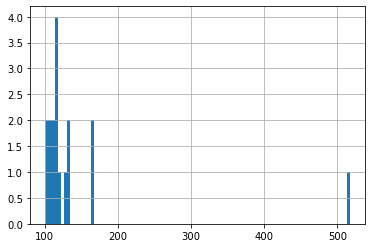

In [232]:
outliers_snw_depth = outlier_identification(dfmi_closest_stations, "SNWD")

## Average temperature

count    3189.000000
mean       26.619574
std        74.227498
min         0.285814
25%        12.813094
50%        21.902693
75%        33.498484
max      2893.243907
Name: distance, dtype: float64

(4, 10)


,state_gazeeter,state_station,counts
0,Northern Mariana Islands,HI,2
1,Maine,ME,1
2,Alaska,AK,1


state_gazeeter state_station     distance               \
                                                  mean       median   
2  Northern Mariana Islands            HI  2888.792954  2888.792954   
0                    Alaska            AK   648.137441   648.137441   
1                     Maine            ME   102.517756   102.517756   

                                  
           min          max  len  
2  2884.342001  2893.243907  2.0  
0   648.137441   648.137441  1.0  
1   102.517756   102.517756  1.0

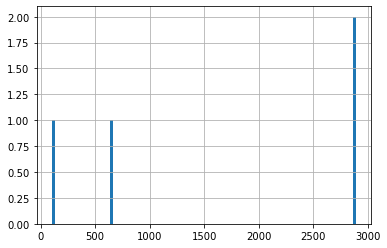

In [233]:
outliers_avg_temp = outlier_identification(dfmi_closest_stations, 
                                           "TAVG" )

## Min temperature

count    3270.000000
mean        9.358852
std        10.506962
min         0.034007
25%         3.924430
50%         7.599904
75%        13.095829
max       467.782916
Name: distance, dtype: float64

(1, 10)


,state_gazeeter,state_station,counts
0,Alaska,AK,1


state_gazeeter state_station    distance                          \
                                      mean      median         min   
0         Alaska            AK  467.782916  467.782916  467.782916   

                    
          max  len  
0  467.782916  1.0

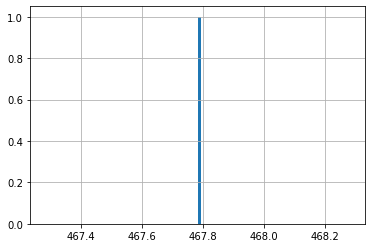

In [234]:
outlier_identification( dfmi_closest_stations, "TMIN")

## Max temperature

count    3270.000000
mean        9.316884
std        10.501826
min         0.034007
25%         3.889294
50%         7.491808
75%        13.014458
max       467.782916
Name: distance, dtype: float64

(1, 10)


,state_gazeeter,state_station,counts
0,Alaska,AK,1


state_gazeeter state_station    distance                          \
                                      mean      median         min   
0         Alaska            AK  467.782916  467.782916  467.782916   

                    
          max  len  
0  467.782916  1.0

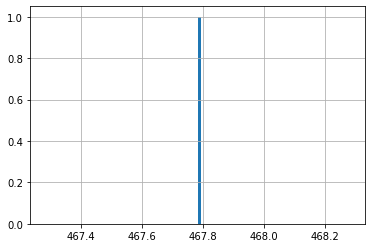

In [235]:
outlier_identification(dfmi_closest_stations, "TMAX")

# set rows to nan for all distances > 100

In [237]:
dfmi_closest_stations.loc[ dfmi_closest_stations["distance"] >100, l_station_cols] = np.nan

In [240]:
dfmi_closest_stations.to_csv( os.path.join(project_path, "OUT_DATA", "closest_stations_filtered.csv"))

In [239]:
project_path

'/home/severine/MOOCS/UDACITY/BIG_DATA/CAPSTONE_PROJECT'